In [5]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import requests
import zipfile
import os.path as path
import scipy.stats as st
%matplotlib inline

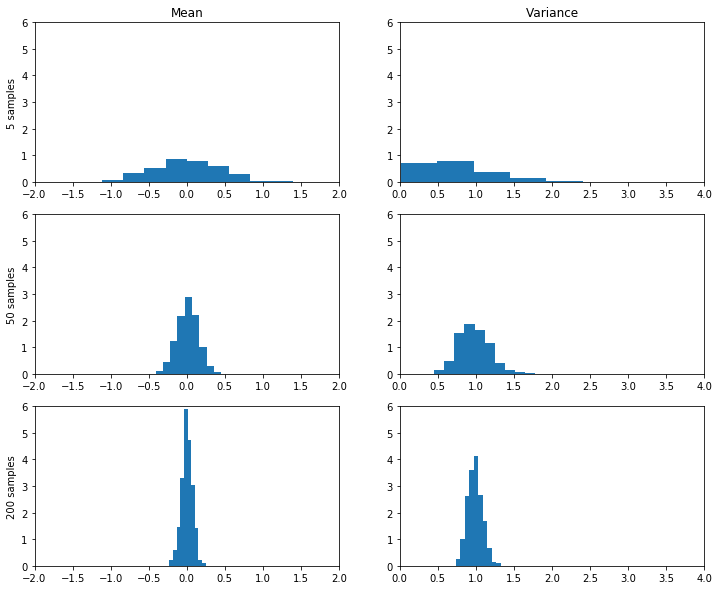

In [69]:
nResamp = 1000
nSamps = [5, 50, 200]
trueMean = 0
trueVar = 1
normal_samples = np.random.normal(loc=trueMean, scale=np.sqrt(trueVar), size=(nResamp, max(nSamps)))
mean_xrange = [-2, 2]
var_xrange = [0, 4]

plt.figure(figsize=(12, 10))
for i in range(len(nSamps)):
    plt.subplot(len(nSamps), 2, i * 2 + 1)
    normal_mean_samples = np.mean(normal_samples[:, 0:nSamps[i]], axis=1)
    plt.hist(normal_mean_samples, normed=True)
    plt.xlim(mean_xrange)
    plt.ylim([0, 6])
    plt.ylabel("%d samples" % nSamps[i])
    if i == 0:
        plt.title('Mean')
        
    plt.subplot(len(nSamps), 2, i * 2 + 2)
    normal_var_samples = np.var(normal_samples[:, 0:nSamps[i]], axis=1)
    plt.hist(normal_var_samples, normed=True)
    plt.xlim(var_xrange)
    plt.ylim([0, 6])
    if i == 0:
        plt.title('Variance')

In [2]:
class Session:
    # a class describing a recording session of this dataset: http://bethgelab.org/datasets/v1gratings/
    
    binWidthSec = 0.01  # spike counts are given in 10 ms bins
    
    trialEndSec = 0.9 # each trial is 900 ms long
    stimulusOnsetSec = 0.2  # in the first 200 ms the screen is blank
    stimulusOffSec = 0.7  # the stimulus is shown fot 500 ms
    onsetTransientSec = 0.15  # the sudden increase in the number of spikes at stimulus onset settled to the stationary evoked level after about 150 ms
    
    # these intervals are typically useful for response statistics analysis
    trialSections = {'postTransient': (stimulusOnsetSec + onsetTransientSec, stimulusOffSec),
                     'stimulus': (stimulusOnsetSec, stimulusOffSec),
                     'preStim': (0, stimulusOnsetSec)}
    
    def __init__(self,matlabData,contaminationThreshold=0.05):
        # the constructor of the class
        # input parameters:
        # matlabData - one session in the format dowloadable from the project website in MAtlab format
        # contaminationThreshold - the contamination value measures the quality of the spike sorting algorithm's output, we can ignore uncertain units above this level
        
        # reading the matlab format introduces a lot of singular dimensions for some reason - I did not figure out a more elegant way to deal with this than the abundance of 0 indices
        contamination = np.squeeze(matlabData[0][0][3])
        
        self.binnedSpikeCounts = matlabData[0][0][5][contamination < contaminationThreshold, :, :, :]
        [self.nCell, self.nCond, self.nBin, self.nTrialPerCond] = self.binnedSpikeCounts.shape
        
        # a condition is a combination of an orientation and a contrast level
        conditions = matlabData[0][0][2]
        # for some reason these are not always in the same order
        orientIdx = 0 if np.squeeze(conditions[0][0][0]) == 0 else 1
        contrastIdx = 1 - orientIdx        
        self.stimOrient = [conditions[0][cnd][orientIdx][0][0] for cnd in range(self.nCond)]
        self.stimContrast = [conditions[0][cnd][contrastIdx][0][0] for cnd in range(self.nCond)]                  
    
    def _selectConditions(self,contrastCondition, orientCondition):
        # this function constructs an index vector that selects the conditions with the specified properties
        if contrastCondition is not None:
            if contrastCondition == 'low':
                contrastCondition = min(self.stimContrast)
            elif contrastCondition == 'high':
                contrastCondition = max(self.stimContrast)
            selectedCondsCtr = self.stimContrast == contrastCondition
        else:
            selectedCondsCtr = np.full(self.nCond, True)
            
        selectedCondsOri = np.full(self.nCond, True) if orientCondition is None else self.stimContrast == contrastCondition   
        return selectedCondsCtr & selectedCondsOri
    
    def _secToBin(sec):
        # the index of the bin in which the specified point in time is contained
        return int(np.floor(sec / Session.binWidthSec))
            
    def getSpikeCounts(self,contrastCondition=None, orientCondition=None, bins=None):
        # the number of spikes in each trial with the specified properties, in the specified interval
        # input parameters:
        # contrastCondition - only trials with this stimulus contrast level are returned. Possible values:
        #     None - all contrast levels
        #     "low" - the lower contrast level from the two used in the session
        #     "high" - the higher contrast level from the two used in the session
        #     numeric value - only use trials with this exact level
        # orientCondition - only trials with this stimulus orientation are returned. Interpreted in degrees.
        # bins - the interval in which to sum up the number of spikes within each trial. 
        #    Possible values are keys in the trialSections class dictionary, any other value including None defaults to the whole trial.
        # output: a numpy array of dimension [number of cells] x [number of selected conditions] x [number of trials per condition]
        #    containing the number of spikes in the specified interval of each trial, for each cell and condition
        
        binsSec = Session.trialSections.get(bins, (0, Session.trialEndSec))
        bins = (Session._secToBin(binsSec[0]), Session._secToBin(binsSec[1]))
        
        return np.sum(self.binnedSpikeCounts[:, self._selectConditions(contrastCondition, orientCondition), bins[0]:bins[1]+1, :], axis=2)
    
    def plotTrialAverage(self,contrastCondition=None, orientCondition=None):
        # plot the firing rate in each bin of a trial averaged over the trials of the specified conditions and each cell
        # input parameters:
        # contrastCondition and orientationCondition interpreted the same way as in the getSpikeCounts method

        plt.plot(np.arange(self.nBin) * Session.binWidthSec, np.mean(self.binnedSpikeCounts[:, self._selectConditions(contrastCondition, orientCondition) ,:, :], axis=(0,1,3)) / Session.binWidthSec)
        plt.xlim((0,(self.nBin-1)*Session.binWidthSec))
        plt.xlabel('time (s)')
        plt.ylabel('mean firing rate (Hz)')
        

def loadEckerData():
    # a function retrieving all the data from the dowloadable dataset from Ecker et al., 2010.
    fname = "data_v1_binned_static"
    if not path.isfile(fname+'.mat'):
        if not path.isfile(fname+'.zip'):
            # if the data is not available locally, dowload it
            r = requests.get("http://bethgelab.org/media/uploads/files/data_v1_binned_static.zip")
            open(fname+'.zip', 'wb').write(r.content)         
        # if the data is compressed, decompress it
        z = zipfile.ZipFile(open(fname+'.zip', 'rb'))
        z.extractall()
    
    # load the saved Matlab variable 'data' from the file
    allData = loadmat(fname+'.mat')['data']
    nSession = allData.shape[0]
    # create a list of Session objects containing the data
    return [Session(allData[sess,0]) for sess in range(nSession)]

# load the data
allSessions = loadEckerData()

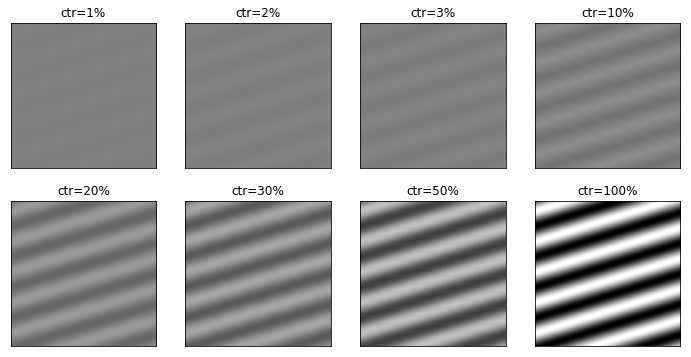

In [3]:
def plotGrating(ax,imSize,wavelength,orientation,contrast):
    # from here: https://stackoverflow.com/questions/19039674/how-can-i-expand-this-gabor-patch-to-the-size-of-the-bounding-box
    
    phase = 0
    # make linear ramp
    X0 = (np.linspace(1, imSize, imSize) / imSize) - .5

    # Set wavelength and phase
    freq = imSize / float(wavelength)
    phaseRad = phase * 2 * np.pi

    # Make 2D grating
    Xm, Ym = np.meshgrid(X0, X0)

    # Change orientation by adding Xm and Ym together in different proportions
    thetaRad = (orientation / 360.) * 2 * np.pi
    Xt = Xm * np.cos(thetaRad)
    Yt = Ym * np.sin(thetaRad)
    grating = np.sin(((Xt + Yt) * freq * 2 * np.pi) + phaseRad) * contrast / 100

    ax.imshow(grating,cmap=plt.cm.gray,vmax=1,vmin=-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (12,6))
                         
for ax, ctr in zip(axes.flat, sorted(set([ctr for s in allSessions for ctr in s.stimContrast]))):
    # for all contrast levels found in the data plot a grating stimulus with arbitrary parameters
    plotGrating(ax,1000,200,73,ctr)
    ax.set_title("ctr=%d%%" % ctr)

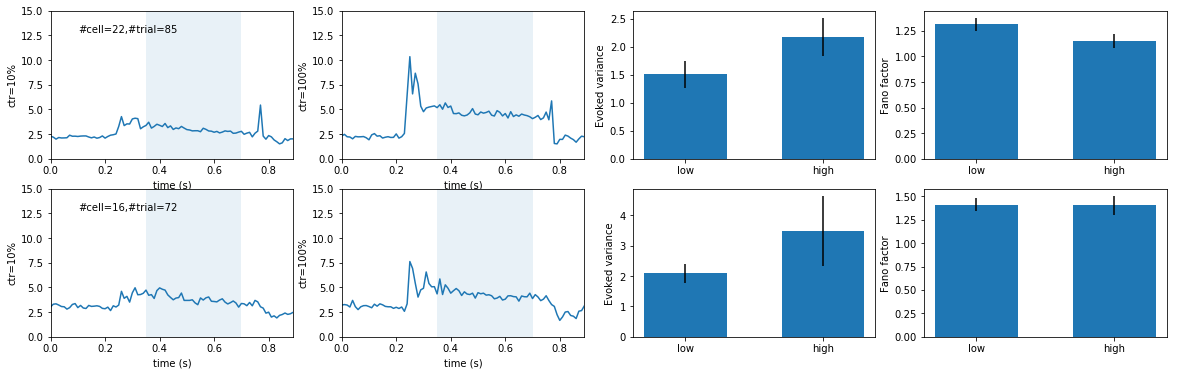

In [4]:
def fanoFactor(a, axis=0):
    ff = np.var(a, axis=axis)
    # where the variance is 0 (which typically occurs when the mean is 0 too), we define the Fano factor to be 0, otherwise variance / mean
    ff[ff > 0] = ff[ff > 0] / np.mean(a, axis=axis)[ff > 0]
    return ff

# we have to decide which sessions to analyze, based on what kind of contrast conditions they use and how many trials per condition do they have 
sessionSet = [s for s in allSessions if min(s.stimContrast)>=10 and s.nTrialPerCond > 50]
binSet = 'postTransient'

# low- and high-contrast spike count variances over trials for each selected session for each cell and condition
low_var = [np.var(sess.getSpikeCounts(bins=binSet,contrastCondition='low'),axis=2).flatten() for sess in sessionSet]
high_var = [np.var(sess.getSpikeCounts(bins=binSet,contrastCondition='high'),axis=2).flatten() for sess in sessionSet]

# low- and high-contrast spike count Fano factors over trials for each selected session for each cell and condition
low_ff = [fanoFactor(sess.getSpikeCounts(bins=binSet,contrastCondition='low'),axis=2).flatten() for sess in sessionSet]
high_ff = [fanoFactor(sess.getSpikeCounts(bins=binSet,contrastCondition='high'),axis=2).flatten() for sess in sessionSet]

shading = Session.trialSections.get(binSet, (0,0.9))

nCol = 4
maxRate = 15
plt.subplots(figsize=(5*nCol, 3*len(sessionSet)))
for sess in range(len(sessionSet)):
    plt.subplot(len(sessionSet),nCol,sess*nCol+1)
    sessionSet[sess].plotTrialAverage(contrastCondition='low')
    plt.ylim((0, maxRate))
    plt.ylabel('ctr=%d%%' % min(sessionSet[sess].stimContrast))
    plt.axvspan(shading[0], shading[1], alpha=0.1, lw=0)
    plt.text(0.1,maxRate*0.85,'#cell=%d,#trial=%d' % (sessionSet[sess].nCell,sessionSet[sess].nTrialPerCond))
    
    plt.subplot(len(sessionSet),nCol,sess*nCol+2)
    sessionSet[sess].plotTrialAverage(contrastCondition='high')
    plt.ylim((0, maxRate))
    plt.ylabel('ctr=%d%%' % max(sessionSet[sess].stimContrast))
    plt.axvspan(shading[0], shading[1], alpha=0.1, lw=0)
    
    plt.subplot(len(sessionSet),nCol,sess*nCol+3)
    plt.bar([0,1],[np.mean(low_var[sess]), np.mean(high_var[sess])],width=0.6,yerr=[st.sem(low_var[sess]), st.sem(high_var[sess])])
    plt.xticks([0,1], ('low', 'high'))
    plt.ylabel('Evoked variance')
    
    plt.subplot(len(sessionSet),nCol,sess*nCol+4)
    plt.bar([0,1],[np.mean(low_ff[sess]), np.mean(high_ff[sess])],width=0.6,yerr=[st.sem(low_ff[sess]), st.sem(high_ff[sess])])
    plt.xticks([0,1], ('low', 'high'))
    plt.ylabel('Fano factor')